## 1. Import Libraries

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import shap                              # For SHAP analysis to explain model predictions
import matplotlib.pyplot as plt          
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV # For model selection and evaluation
from sklearn.preprocessing import StandardScaler, OrdinalEncoder # For feature preprocessing
from sklearn.compose import ColumnTransformer # For combining preprocessing steps
from sklearn.ensemble import RandomForestClassifier # The machine learning model
from sklearn.metrics import accuracy_score, classification_report # For performance evaluation
from imblearn.pipeline import Pipeline as ImbPipeline  # For creating pipelines that handle imbalanced datasets

## 2. Load and Prepare the Dataset

In [2]:
# Load the dataset from a CSV file
df = pd.read_csv("RF inputs.csv")

# Display the first five rows to inspect the data.
df.head()

,No,classification,PGR,P-PET,Leak,GW_Abs,Pop_den,Irri_int,Aquifer
0,1,Decreasing,94.053635,131.665070,3.332,13.058,48.981932,101,Oolites
1,2,No trend,183.882095,152.268936,36.032,42.555,120.716050,251,Oolites
2,3,No trend,15.880354,98.122665,8.174,41.780,139.429724,1001,Carboniferous Limestone
3,4,Sudden upward change,18.850481,41.858784,4.342,13.058,108.535389,5001,Lower Greensand
4,6,Increasing,219.945038,162.090027,9.786,16.604,73.251734,1001,Permian Sandstone


In [3]:
# Define target variable
y = df["classification"]

# Define input variable
X = df.drop(columns=["No", "classification", "PGR"]) # replaced by P–PET if PRG is chosen as input variable

# Identify categorical and numerical feature types
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

# Define Data Preprocessing Steps
transformers = [("num", StandardScaler(), num_features)] # Standardize numerical features for consistent scale
if len(cat_features) > 0:
    transformers.append(("cat", OrdinalEncoder(), cat_features)) # Ordinally encode categorical features to convert them to numbers

# Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=transformers)

# Apply preprocessing to the full dataset (No train/test split here since SHAP analysis is applied to the entire set)
X_transformed = preprocessor.fit_transform(X)

# Collect final feature names for SHAP visualization
feature_names = list(num_features)
if len(cat_features) > 0:
    cat_feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_features)
    feature_names += list(cat_feature_names)

## 3. Hyperparameter Tuning with Randomized Search

In [4]:
# Define the pipeline, combining preprocessing and the classifier
pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(
        class_weight="balanced",  # Adjusts for imbalanced classes
        random_state=42,          # Ensures reproducibility
        n_jobs=-1                 # Uses all available CPU cores
    ))
])

# Define the hyperparameter search space for RandomizedSearchCV
param_dist = {
    "clf__n_estimators": [200, 500],
    "clf__max_depth": [5, 8, 12],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["log2"]
}

# Set up 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configure the randomized search
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,                 # Number of parameter settings to sample
    scoring="f1_weighted",     # Metric to optimize
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Execute the search on the data
search.fit(X, y)

# Print the best hyperparameters found
print("Best parameters found:", search.best_params_)

# Print the best cross-validation score achieved
print("Best CV score:", search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'clf__n_estimators': 500, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__max_depth': 12}
Best CV score: 0.5777091619335913


## 4. Model Evaluation using Cross-Validation

In [5]:
# Initialize the RandomForestClassifier with the best parameters found
rf_cv = RandomForestClassifier(
    n_estimators=500,
    max_depth=12,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features="log2",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

In [6]:
all_reports = []
all_acc = []
importances = []

# Manually loop through each cross-validation fold
for train_idx, test_idx in cv.split(X, y):
    # Train the model on the training data for this fold
    rf_cv.fit(X_transformed[train_idx], y.iloc[train_idx])
    
    # Make predictions on both training and test sets
    y_pred_train = rf_cv.predict(X_transformed[train_idx])
    y_pred_test = rf_cv.predict(X_transformed[test_idx])
    
    # Store results for this fold
    importances.append(rf_cv.feature_importances_)
    acc_train = accuracy_score(y.iloc[train_idx], y_pred_train)
    acc_test = accuracy_score(y.iloc[test_idx], y_pred_test)
    all_acc.append((acc_train, acc_test))
    report = classification_report(y.iloc[test_idx], y_pred_test, output_dict=True, zero_division=0)
    all_reports.append(report)

# Aggregate and display performance metrics
acc_train_mean, acc_train_std = np.mean([a for a, _ in all_acc]), np.std([a for a, _ in all_acc])
acc_test_mean, acc_test_std   = np.mean([b for _, b in all_acc]), np.std([b for _, b in all_acc])

print(f"Train Accuracy: {acc_train_mean:.3f} ± {acc_train_std:.3f}")
print(f"Test  Accuracy: {acc_test_mean:.3f} ± {acc_test_std:.3f}")

Train Accuracy: 0.941 ± 0.003
Test  Accuracy: 0.585 ± 0.015


## 5. Training the Final Model

In [7]:
# Define the final model with the optimal parameters
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=12,
    min_samples_leaf=1,     
    min_samples_split=2,    
    max_features="log2",    
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

In [8]:
# Train the final model on the entire transformed dataset
rf.fit(X_transformed, y)

# Generate predictions on the training data to see how well it fits
train_preds = rf.predict(X_transformed)
print(classification_report(y, train_preds))

                        precision    recall  f1-score   support

            Decreasing       0.86      0.93      0.89       403
            Increasing       0.88      0.92      0.90       719
              No trend       0.96      0.92      0.94      1641
Sudden downward change       0.86      1.00      0.93        37
  Sudden upward change       0.97      1.00      0.99       102

              accuracy                           0.92      2902
             macro avg       0.91      0.95      0.93      2902
          weighted avg       0.92      0.92      0.92      2902



## 6. SHAP (SHapley Additive exPlanations) Analysis

In [9]:
# Initialize the SHAP explainer with the trained Random Forest model
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values for all data points
shap_values = explainer.shap_values(X_transformed)

### 6.1. Global Feature Importance

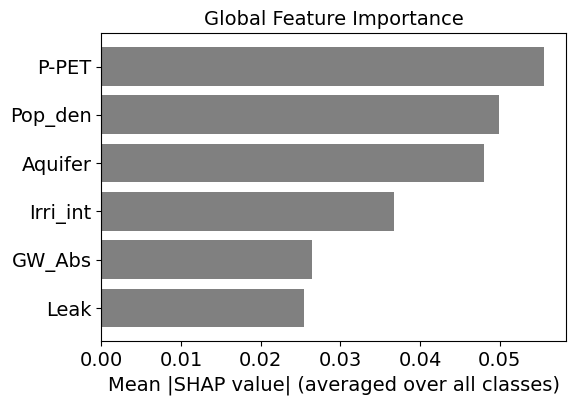

In [10]:
# Calculate the mean absolute SHAP value for each feature
mean_abs_shap = np.mean(np.abs(shap_values), axis=(0,2))

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": mean_abs_shap
}).sort_values("importance", ascending=True)

# Create a horizontal bar plot of feature importances
plt.figure(figsize=(6, 4))
plt.barh(importance_df["feature"], importance_df["importance"], color='grey')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Mean |SHAP value| (averaged over all classes)", fontsize=14)
plt.title("Global Feature Importance", fontsize=14)
plt.show()

### 6.2. SHAP Summary Plot for "Increasing" Class

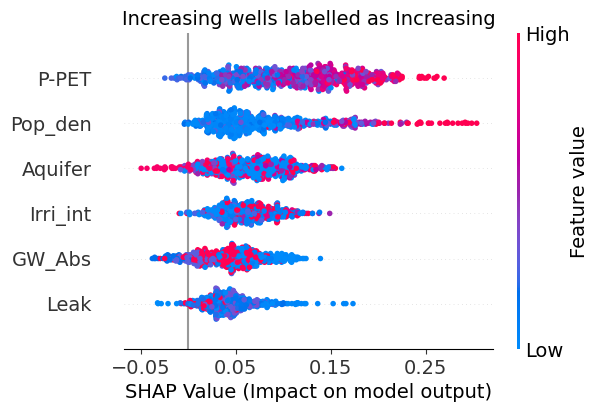

In [11]:
# SHAP Summary for wells that are truly 'Increasing'
target_class = "Increasing"

# Get the index for the target class
class_mapping = {cls: idx for idx, cls in enumerate(rf.classes_)}
class_idx = class_mapping[target_class]

# Filter the data and SHAP values for this class
mask = (y == target_class)
X_subset = X_transformed[mask]
shap_subset = shap_values[mask, :, class_idx]

# Generate the summary plot
shap.summary_plot(
    shap_subset,
    X_subset,
    feature_names=feature_names,
    show=False,
    plot_size=(6,4),
    color_bar=True
)
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=14)
cbar.set_ylabel("Feature value", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(np.arange(-0.05, 0.3, 0.1), fontsize=14)
plt.title("Increasing wells labelled as Increasing", fontsize=14)
plt.xlabel("SHAP Value (Impact on model output)", fontsize=14)
plt.show()

### 6.3. SHAP Summary Plot for "Decreasing" Class

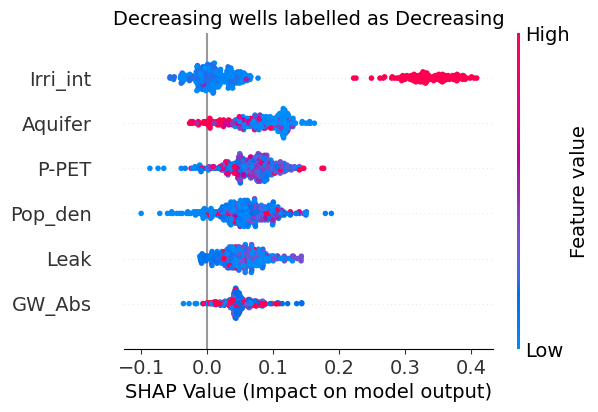

In [12]:
# SHAP Summary for wells that are truly 'Decreasing'
target_class = "Decreasing"

# Get the index for the target class
class_mapping = {cls: idx for idx, cls in enumerate(rf.classes_)}
class_idx = class_mapping[target_class]

# Filter the data and SHAP values for this class
mask = (y == target_class)
X_subset = X_transformed[mask]
shap_subset = shap_values[mask, :, class_idx]

# Generate the summary plot
shap.summary_plot(
    shap_subset,
    X_subset,
    feature_names=feature_names,
    show=False,
    plot_size=(6, 4)
)
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=14)
cbar.set_ylabel("Feature value", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title("Decreasing wells labelled as Decreasing", fontsize=14)
plt.xlabel("SHAP Value (Impact on model output)", fontsize=14)
plt.show()

### 6.4. Individual Prediction Analysis (Waterfall Plot)

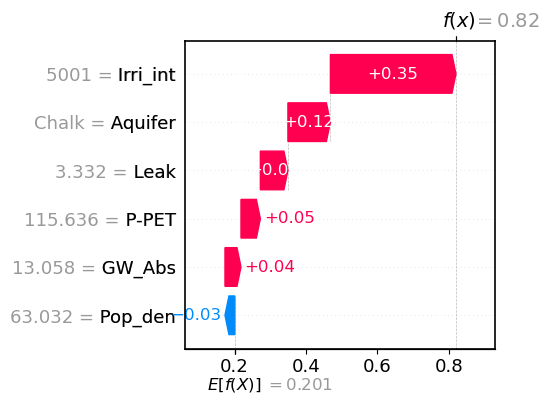

In [13]:
# Select the 'Decreasing' class for analysis
target_class = "Decreasing"
class_mapping = {cls: idx for idx, cls in enumerate(rf.classes_)}
class_idx = class_mapping[target_class]

# Filter to get only the wells from this class
mask = (y == target_class)
X_subset = X[mask].reset_index(drop=True)
shap_subset = shap_values[mask, :, class_idx]

# --- Explain a Single Prediction ---
# Pick one sample to explain (e.g., the 27th 'Decreasing' well)
sample_idx = 27
sample_data = X_subset.iloc[sample_idx].values
sample_shap = shap_subset[sample_idx]
feature_name = X_subset.iloc[sample_idx].index

# Create a SHAP Explanation object for the single sample
exp = shap.Explanation(
    values=sample_shap,
    base_values=explainer.expected_value[class_idx],
    data=sample_data,
    feature_names=feature_name
)

# Generate and customize the waterfall plot
shap.plots.waterfall(exp, show=False)
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(4, 4)
plt.yticks(fontsize=36)
plt.xticks(fontsize=14)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)
    spine.set_color("black")
plt.show()

### 6.5. Exporting SHAP Values for Analysis

In [15]:
# Create a list to store records for each sample
records = []

X_array = np.array(X_transformed)
proba = rf.predict_proba(X_transformed)

# Iterate through each sample to extract its SHAP information
for i in range(len(y)):
    true_class = y.iloc[i]
    class_idx = class_mapping[true_class]
    predicted_class = rf.classes_[np.argmax(proba[i])]
    shap_for_sample = shap_values[i, :, class_idx]
    sample_probs = proba[i, class_idx]
    
    # Find the top feature by sorting absolute SHAP values
    abs_shap = np.abs(shap_for_sample)
    sorted_idx = np.argsort(abs_shap)[::-1]
    top_features = [feature_names[j] for j in sorted_idx[:1]]

    # Build a dictionary with all relevant information
    record = {
        "TrueClass": true_class,
        "PredictClass": predicted_class,
        "Prob_True": sample_probs,
        "TopFeatures": ", ".join(top_features)
    }

    # Add each feature's specific SHAP value to the record
    for feature_idx, feature_name in enumerate(feature_names):
        record[feature_name] = shap_for_sample[feature_idx]

    records.append(record)

# Convert the list of records into a DataFrame
df_shap = pd.DataFrame(records)

In [16]:
df_shap

,TrueClass,PredictClass,Prob_True,TopFeatures,P-PET,Leak,GW_Abs,Pop_den,Irri_int,Aquifer
0,Decreasing,Decreasing,0.522682,P-PET,0.093559,0.063096,0.047768,0.057347,0.026290,0.034044
1,No trend,No trend,0.836538,Aquifer,0.146477,0.047887,0.049888,0.155331,0.056614,0.180032
2,No trend,No trend,0.747577,P-PET,0.146283,0.070578,0.060483,0.120675,0.068934,0.080315
3,Sudden upward change,Sudden upward change,0.802517,Aquifer,0.139802,0.069107,0.003140,0.011763,0.171781,0.208883
4,Increasing,Increasing,0.370669,Pop_den,0.016498,0.014194,-0.000585,0.057527,0.047888,0.035114
...,...,...,...,...,...,...,...,...,...,...
2897,No trend,No trend,0.629562,P-PET,0.107266,0.047419,0.073771,0.077359,0.059614,0.063824
2898,Increasing,Increasing,0.591836,P-PET,0.148440,0.032827,0.037887,0.099593,0.049101,0.023956
2899,No trend,No trend,0.740201,Pop_den,0.099554,0.057346,0.074422,0.183928,0.059098,0.065545
2900,No trend,No trend,0.788024,Pop_den,0.136116,0.047891,0.068276,0.186893,0.075394,0.073145
